In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

In [2]:
path = '../../../data'
train = pd.read_csv(path + '/train_data.csv')

In [3]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [4]:
train.dtypes

userID               int64
assessmentItemID    object
testId              object
answerCode           int64
Timestamp           object
KnowledgeTag         int64
dtype: object

범주형 데이터
1) 명목형(nominal) 데이터 - userID, assessmentItemID, answerCode, KnowledgeTag
2) 순서형(ordinal) 데이터 - x

수치형 데이터
1) 연속형(continuous) 데이터 - Timestamp
2) 이산형 (descrete) 데이터 - x

1. 데이터 압축

In [5]:
def _compress_numeric_column(col,
                             max_loss_limit=0.001,
                             avg_loss_limit=0.001,
                             na_loss_limit=0,
                             n_uniq_loss_limit=0,
                             fillna=0):
                             
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)

    try_types = ['float16', 'float32']
    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    # try downcast to type which the size is smallest to largest 
    for try_type in try_types:
        col_tmp = col

        # float to int conversion
        # try to round to minimize casting error
        if is_float and (str(try_type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        # downcast
        col_tmp = col_tmp.astype(try_type)

        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        # If every condition matches than return that column
        if (max_loss <= max_loss_limit and
            avg_loss <= avg_loss_limit and
            na_loss <= na_loss_limit and
            n_uniq_loss <= n_uniq_loss_limit):
            return col_tmp

    # failed to downcast the column
    return col

In [6]:
def compress_df(df, deep=True, verbose=False, obj_to_cat=False):

    numerics = ['int16',
                'uint16',
                'int32',
                'uint32',
                'int64',
                'uint64',
                'float16',
                'float32',
                'float64']

    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        
        # numerics
        if col_type in numerics:
            df[col] = _compress_numeric_column(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [7]:
train = compress_df(train, verbose=True)

Column userID: int64 -> int16
Column assessmentItemID: object -> object
Column testId: object -> object
Column answerCode: int64 -> int8
Column Timestamp: object -> object
Column KnowledgeTag: int64 -> int16
Mem. usage decreased from 505.81 Mb to 464.74 Mb (8.1% reduction)


2. 이상치 탐지

In [8]:
train.KnowledgeTag.nunique()

912

In [9]:
tem = train.groupby('userID')['answerCode']
tem = pd.DataFrame({'mean' : tem.mean(), 'cnt':tem.count()}).reset_index()
tem

,userID,mean,cnt
0,0,0.630872,745
1,1,0.853162,933
2,2,0.612319,276
3,5,0.795918,833
4,6,0.442997,921
...,...,...,...
6693,7436,0.466667,15
6694,7437,0.375000,16
6695,7438,0.750000,16
6696,7440,0.400000,15


Text(0.5, 1.0, '# of Questions - Answer Rate')

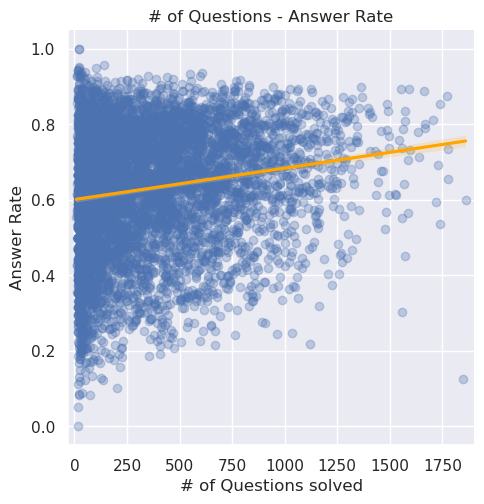

In [10]:
#문제 푼 개수와 정답률 사이의 상관관계

g = sns.lmplot(
    data=tem,
    x='cnt',
    y='mean',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [11]:
tem = train.groupby('KnowledgeTag')['answerCode']
tem = pd.DataFrame({'mean':tem.mean(), 'cnt':tem.count()}).reset_index()
tem

,KnowledgeTag,mean,cnt
0,23,0.584444,1800
1,24,0.614525,358
2,25,0.858696,92
3,26,0.614309,2432
4,30,0.536178,539
...,...,...,...
907,11253,0.739374,4282
908,11265,0.676211,454
909,11269,0.557716,2417
910,11270,0.478927,261


Text(0.5, 1.0, '# of Tags Exposed - Answer Rate')

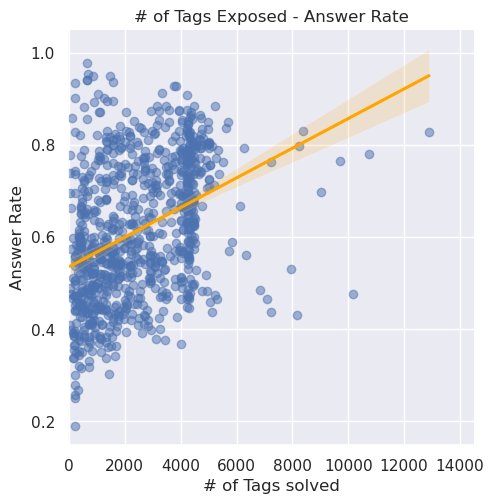

In [12]:
#태그 노출 횟수와 정답률 사이의 상관관계

g = sns.lmplot(
    data=tem,
    x='cnt',
    y='mean',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate')

<AxesSubplot:ylabel='answerCode'>

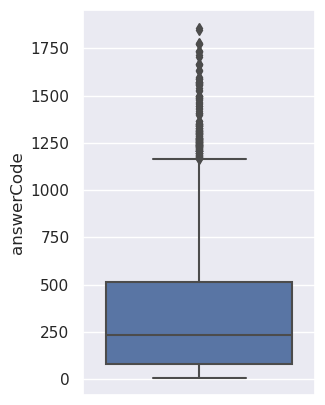

In [13]:
#푼 문제의 개수가 너무 적은 유저가 있는지 확인

plt.figure(figsize=(3,5))
sns.boxplot(y=train.groupby('userID')['answerCode'].count())

3. 이상치 제거

IQR(Interquartile Range) : Q1−1.5 IQR ∼ Q3+1.5 IQR  사이의 값을 벗어나는 모든 값을 이상치라고 가정하는 방법

In [14]:
# 태그 노출 횟수 - 정답률에서의 이상치

Q1 = tem['mean'].quantile(0.25)
Q3 = tem['mean'].quantile(0.75)

# IQR 계산하기
IQR = Q3 - Q1

# 이상치 경계선 계산
low_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

low_outlier = tem['mean'] <= low_bound
upper_outlier = tem['mean'] >= upper_bound

outlier = low_outlier | upper_outlier

# 이상치 표시
tem.loc[outlier]

,KnowledgeTag,mean,cnt


In [15]:
tem = train.groupby('userID')['answerCode']
tem = pd.DataFrame({'mean' : tem.mean(), 'cnt':tem.count()}).reset_index()
tem

,userID,mean,cnt
0,0,0.630872,745
1,1,0.853162,933
2,2,0.612319,276
3,5,0.795918,833
4,6,0.442997,921
...,...,...,...
6693,7436,0.466667,15
6694,7437,0.375000,16
6695,7438,0.750000,16
6696,7440,0.400000,15


In [16]:
#문제 푼 개수 - 정답률에서의 이상치

Q1 = tem['mean'].quantile(0.25)
Q3 = tem['mean'].quantile(0.75)

# IQR 계산하기
IQR = Q3 - Q1

# 이상치 경계선 계산
low_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

low_outlier = tem['mean'] <= low_bound
upper_outlier = tem['mean'] >= upper_bound

outlier = low_outlier | upper_outlier

# 이상치 표시
tem.loc[outlier]

,userID,mean,cnt
433,481,0.124526,1847
1691,1889,0.184211,228
1738,1942,0.155963,218
1976,2215,0.191176,408
2438,2725,0.176471,187
2560,2857,0.185915,355
2758,3074,0.129032,124
3434,3821,0.123188,138
3852,4273,0.190476,210
3894,4316,0.176991,113


4. 인코딩

인코딩은 범주형 feature를 수치형으로 변환하는 것

In [17]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [18]:
#문제를 푸는 데 걸린 시간 column 추가

# train['spent_time'] = 0

# for user in train['userID'].unique():
#     print('userID=',user)
#     print()
#     tmp = train.loc[train['userID']==user]

#     lst = [0]
    
#     for i in range(1, len(tmp)-1):
#         sec = (tmp['Timestamp'][i+1] - tmp['Timestamp'][i]).seconds
#         if sec >= 600:
#                 lst.append(lst[-1])
#         elif sec == 0:
#             lst.append(lst[-1])

#         else:
#             lst.append(sec)

#     lst.append(lst[-1])
#     lst[0] = lst[1]

#     print(len(lst))

#     train.loc[train['userID']==user].spent_time = lst
#     print(train.loc[train['userID']==user].spent_time)
#     print(tmp['spent_time'])

In [19]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [20]:
#시험지 번호, 문제 번호 추가

train['test_paper'] = train['assessmentItemID'].str[4:7]
train['problem_id'] = train['assessmentItemID'].str[-3:]

In [21]:
#난이도, 학년 등 추정되는 번호 추가

train['category_2'] = train['assessmentItemID'].str[2]

In [22]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_paper,problem_id,category_2
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,001,001,6
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,001,002,6
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,001,003,6
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,001,004,6
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,001,005,6


In [23]:
#인코딩에 필요 없는 column 삭제

train = train.drop(columns='assessmentItemID')
train = train.drop(columns='testId')
train.head()

,userID,answerCode,Timestamp,KnowledgeTag,test_paper,problem_id,category_2
0,0,1,2020-03-24 00:17:11,7224,001,001,6
1,0,1,2020-03-24 00:17:14,7225,001,002,6
2,0,1,2020-03-24 00:17:22,7225,001,003,6
3,0,1,2020-03-24 00:17:29,7225,001,004,6
4,0,1,2020-03-24 00:17:36,7225,001,005,6


인코딩은 성능 차이가 많이 나게 하는 중요한 요소는 아니다. 사용하는 모델이 트리 모델이면 더욱 상관없음 
다만 인코딩하는 feature의 cardinality가 커질 경우 트리 모델에서의 성능 차이가 많이 벌어지므로 신중히 선택해야함

Cardinality

중복도가 ‘낮으면’ 카디널리티가 ‘높다’고 표현한다.

중복도가 ‘높으면’ 카디널리티가 ‘낮다’고 표현한다.

카디널리티는 전체 행에 대한 특정 컬럼의 중복 수치를 나타내는 지표

예시 :

주민등록번호 - 중복되는 값 x, cardinality '높음'
이름 - 중복되는 값 많음, 위의 경우에 ((비해)) cardinality '낮음'
((비해)) 강조 이유 - 카디널리티는 상대적인 개념으로 이해해야 한다고 함

In [24]:
from sklearn.preprocessing import OrdinalEncoder

In [25]:
encoder = OrdinalEncoder()

# 근데 인코딩해줄 feature가 아직 딱히 안만들어졌다

5. transform

데이터 분포 자체를 변화시키는 것을 트랜스폼이라고 함. (<-> 스케일링 : 분포 변화 x, 분포의 스케일만 변화)
모델이 데이터 사이의 패턴을 더 쉽게 파악할 수 있는 효과

In [26]:
# QuantileTransformer 중 확률 분포를 정규 분포로 변환해주는 트랜스포머를 사용함

from sklearn.preprocessing import QuantileTransformer

In [27]:
# 일단 timestamp 사용 안할거니 삭제, 나중에 유용한 변수로 쓸 방법을 찾으면 그때 끼워주면 좋을듯

train = train.drop(columns='Timestamp')

In [28]:
train.KnowledgeTag.to_numpy()

array([7224, 7225, 7225, ..., 8836, 8836, 8836], dtype=int16)

In [29]:
tag_trans = QuantileTransformer(output_distribution='normal').fit_transform(train.KnowledgeTag.to_numpy().reshape(-1,1))

In [30]:
tag_trans

array([[0.31760072],
       [0.31896936],
       [0.31896936],
       ...,
       [1.14489597],
       [1.14489597],
       [1.14489597]])

Text(0.5, 1.0, 'Normal Quantile transformed skewed distribution')

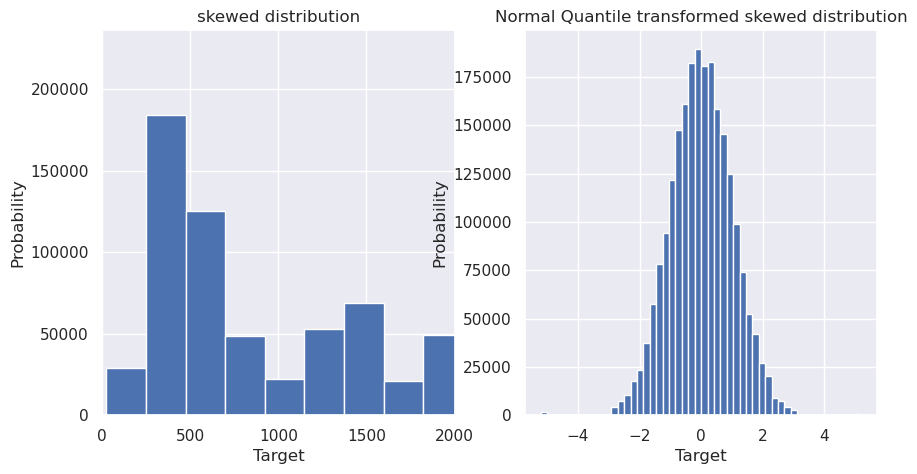

In [31]:
# 그래프 그리기
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.hist(train['KnowledgeTag'], bins=50 )
plt.xlim([0, 2000])
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('skewed distribution')

fig.add_subplot(1, 2, 2)
plt.hist(tag_trans, bins=50)
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('Normal Quantile transformed skewed distribution')

In [32]:
train['KnowledgeTag'] = tag_trans
train.head()

,userID,answerCode,KnowledgeTag,test_paper,problem_id,category_2
0,0,1,0.317601,001,001,6
1,0,1,0.318969,001,002,6
2,0,1,0.318969,001,003,6
3,0,1,0.318969,001,004,6
4,0,1,0.318969,001,005,6


In [33]:
paper_trans = QuantileTransformer(output_distribution='normal').fit_transform(train.test_paper.to_numpy().reshape(-1,1))
train['test_paper'] = paper_trans

prob_trans = QuantileTransformer(output_distribution='normal').fit_transform(train.problem_id.to_numpy().reshape(-1,1))
train['problem_id'] = prob_trans

cate2_trans = QuantileTransformer(output_distribution='normal').fit_transform(train.category_2.to_numpy().reshape(-1,1))
train['category_2'] = cate2_trans

In [34]:
train.head()

,userID,answerCode,KnowledgeTag,test_paper,problem_id,category_2
0,0,1,0.317601,-5.199338,-5.199338,0.401995
1,0,1,0.318969,-5.199338,-0.686350,0.401995
2,0,1,0.318969,-5.199338,-0.227777,0.401995
3,0,1,0.318969,-5.199338,0.186756,0.401995
4,0,1,0.318969,-5.199338,0.628724,0.401995


6. scaling

스케일링으로 데이터 분포의 범위를 조절해줄 수 있다. 회귀나 딥러닝에서 매우 중요한 비중 차지. 값의 범위가 매우 상이할 때 스케일링 안하면 학습 불안정해지기 때문

robust scaler : 중간값과 IQR을 사용하여 스케일링하기 때문에 이상치에 영향을 덜 받는다.

In [37]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler
# scaler.transform(train['KnowledgeTag'])